# Comparison of Station Data and HRDPS

In [128]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math

In [2]:
#bring in data
#hrdps = xr.open_dataset("hrdps_day_avgs_postSep2014.nc")
racerocks = pd.read_csv("RaceRocks.csv")
#sheringham = pd.read_csv("Sheringham.csv")

In [3]:
#bring in PCA results
direc_eigvecs = pd.read_csv('direc_hrdps_eigvecs.csv',header=None).to_numpy()
direc_fracvar = pd.read_csv('direc_hrdps_fracVar.csv',header=None)[0].to_numpy()
direc_PCs = pd.read_csv('direc_hrdps_PCs.csv',header=None).to_numpy()
speed_eigvecs = pd.read_csv('speed_hrdps_eigvecs.csv',header=None).to_numpy()
speed_fracvar = pd.read_csv('speed_hrdps_fracVar.csv',header=None)[0].to_numpy()
speed_PCs = pd.read_csv('speed_hrdps_PCs.csv',header=None).to_numpy()

hrdps_lat = pd.read_csv('hrdps_lat.csv',header=None)[0].to_numpy()
hrdps_lon = pd.read_csv('hrdps_lon.csv',header=None)[0].to_numpy()

In [29]:
#bring in seasonal cycle results
season_speed = pd.read_csv('speed_daily_seasonal.csv',header=None).to_numpy()
season_direc = pd.read_csv('direc_daily_seasonal.csv',header=None).to_numpy()

In [17]:
#generate dates that current extend of hrdps data falls within
time2015 = pd.date_range(start=datetime.datetime(2015,1,1),end=datetime.datetime(2020,12,31))
time2015 = np.delete(time2015,[list(time2015).index(datetime.datetime(2016,2,29)),list(time2015).index(datetime.datetime(2020,2,29))])

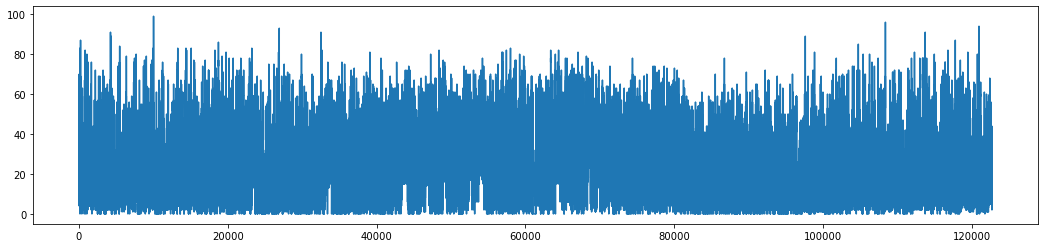

In [5]:
#plot the wind data at both stations
plt.figure(figsize=(18,4))
plt.plot(racerocks['Wind Spd (km/h)'])
#plt.plot(sheringham['Wind Spd (km/h)']) #much more gaps in sheringham wind data (pressure is comparible), focus on racerocks

In [6]:
racerocks['Date/Time (LST)']=pd.to_datetime(racerocks['Date/Time (LST)'])

In [7]:
racerocks['Date/Time (LST)']

0        2007-01-01 00:00:00
1        2007-01-01 01:00:00
2        2007-01-01 02:00:00
3        2007-01-01 03:00:00
4        2007-01-01 04:00:00
                 ...        
122731   2020-12-31 19:00:00
122732   2020-12-31 20:00:00
122733   2020-12-31 21:00:00
122734   2020-12-31 22:00:00
122735   2020-12-31 23:00:00
Name: Date/Time (LST), Length: 122736, dtype: datetime64[ns]

In [8]:
#take Race Rocks daily average
RR_davg = racerocks.resample('D', on='Date/Time (LST)').mean()

In [23]:
#trim racerocks data to be for same time extent as hrdps
RR_davg = RR_davg[min(time2015):max(time2015)]
RR_davg = RR_davg.drop([datetime.datetime(2016,2,29),datetime.datetime(2020,2,29)],axis=0)

## Find the index of the closest HRDPS grid cell to Race Rocks

In [10]:
# hrdps_lat = hrdps.nav_lat.values.flatten()
# hrdps_lon = hrdps.nav_lon.values.flatten()

In [11]:
#want to isolate HRDPS data from nav_lat and nav_lon close to RaceRocks
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

#Racerocks located at lat =48.3 lon =-123.53
lat = racerocks['Latitude (y)'][0]
lon = racerocks['Longitude (x)'][0]+360 #the lat and lon we want to aim for
buffer = 0.01 #play around in this until narrowed in on one best values
ind=0

for i in range(len(hrdps_lon)):
    if hrdps_lon[i] > (lon-buffer) and hrdps_lon[i] < (lon+buffer) and hrdps_lat[i] > (lat-buffer) and hrdps_lat[i] < (lat+buffer):
        ind=i

# closest = find_nearest(hrdps_lat,racerocks['Latitude (y)'][0])
# lat_ind = np.where(hrdps_lat == closest)[0][0]

# closest = find_nearest(hrdps_lon,racerocks['Longitude (x)'][0]+360)
# lon_ind = np.where(hrdps_lon == closest)[0][0]

print('HRDPS closest lat= '+str(hrdps_lat[ind])+', closest lon= '+str(hrdps_lon[ind]))

HRDPS closest lat= 48.29035764694796, closest lon= 236.4652931642128


*Trim eigenvectors according according to this index*

In [12]:
speed_eigvecs = speed_eigvecs[:,ind]
direc_eigvecs = direc_eigvecs[:,ind]

## Reconstruction
Speed:

In [175]:
#determine the number of modes required for x% variance to be explained in speed
x= 0.90
kk = 0

for i in range(len(speed_fracvar)):
    kk+=speed_fracvar[i]
    if kk >= x:
        n=i 
        break
print(str(n)+" modes required to account for " +str(x*100)+"% of the variance.")

7 modes required to account for 90.0% of the variance.


In [176]:
#reconstruct 
eigvecs = speed_eigvecs[:,np.newaxis]
REC = eigvecs[:n,:].T@speed_PCs[:,:n].T# + np.mean(pd.DataFrame.to_numpy(d[2:]))
REC = REC[0,:]

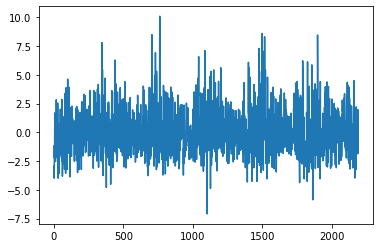

In [177]:
plt.plot(REC)

In [178]:
#add seasonal cycle back
#first we need to remove all irrelevant infro from season_speed (only care about the tile closest to RaceRocks)
#season_speed = season_speed[ind,:]

#then make this cycle for the full 6 year run and add to the reconstructed data
nyears=6
REC = REC+ np.tile(season_speed,(1,nyears))
REC = REC[0,:]

In [179]:
#calculate the correlation between racerocks and HRDPS
r = np.corrcoef(REC,RR_davg['Wind Spd (km/h)']*1000*(1/3600))[0][1]

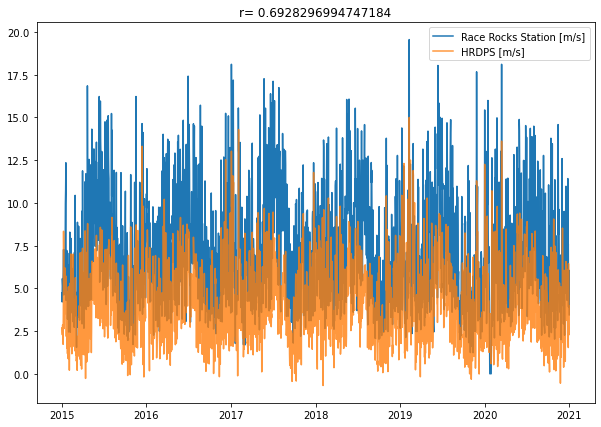

In [180]:
plt.figure(figsize=(10,7))
plt.plot(time2015,RR_davg['Wind Spd (km/h)']*1000*(1/3600),label='Race Rocks Station [m/s]')#,alpha=0.9)
plt.plot(time2015,REC,alpha=0.8,label='HRDPS [m/s]')
plt.title('r= '+str(r))
plt.legend()

Direction:

In [181]:
#determine the number of modes required for x% variance to be explained in direction
x= 0.90
kk = 0

for i in range(len(direc_fracvar)):
    kk+=direc_fracvar[i]
    if kk >= x:
        n=i 
        break
print(str(n)+" modes required to account for " +str(x*100)+"% of the variance.")

306 modes required to account for 90.0% of the variance.


In [182]:
#reconstruct 
eigvecs = direc_eigvecs[:,np.newaxis]
REC = eigvecs[:n,:].T@direc_PCs[:,:n].T# + np.mean(pd.DataFrame.to_numpy(d[2:]))
REC = REC[0,:]

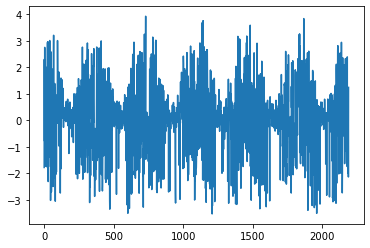

In [183]:
plt.plot(REC)

In [184]:
#add seasonal cycle back
#first we need to remove all irrelevant infro from season_speed (only care about the tile closest to RaceRocks)
#season_direc = season_direc[ind,:]

#then make this cycle for the full 6 year run and add to the reconstructed data
nyears=6
REC = REC+ np.tile(season_direc,(1,nyears))
REC = REC[0,:]

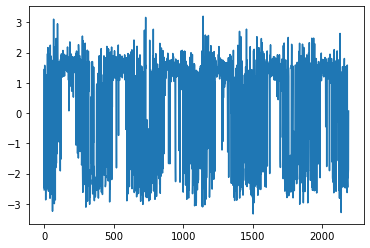

In [185]:
plt.plot(REC)

In [186]:
#HRPDS direction results are in +ve and -ve radians, must convert to degrees between 0 and 360
for i in range(len(REC)):
    if REC[i] >0:
        REC[i] = REC[i]*(180/math.pi)
    if REC[i] <0:
        REC[i] = REC[i]*(180/math.pi)+360

In [187]:
#calculate the correlation between racerocks and HRDPS
r = np.corrcoef(REC,RR_davg['Wind Dir (10s deg)']*10)[0][1]

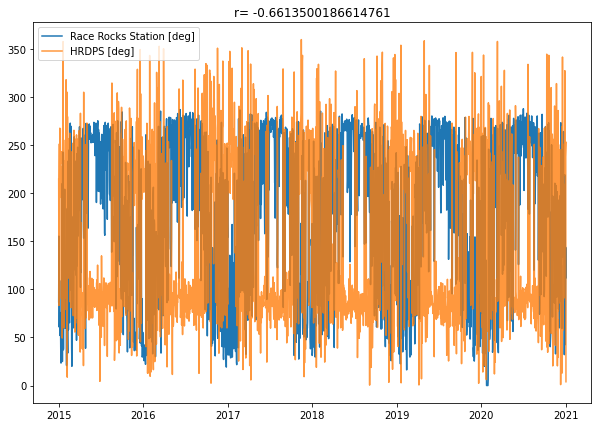

In [188]:
plt.figure(figsize=(10,7))
plt.plot(time2015,RR_davg['Wind Dir (10s deg)']*10,label='Race Rocks Station [deg]')#,alpha=0.9)
plt.plot(time2015,REC,alpha=0.8,label='HRDPS [deg]')
plt.title('r= '+str(r))
plt.legend()